In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from itertools import cycle
import random
from collections import Counter
from tqdm import tqdm
from vips import vipp

In [3]:

## ALREADY PREPROCESSED 
#### Min gene count = 0 for 15% of samples

train_fpkm = pd.read_csv("../data/train_fpkm_minfilter0_log2.csv",sep='\t',index_col=0)
train_meta = pd.read_csv('../data/meta_reseq.csv', sep='\t', index_col='sample_id')

test_fpkm = pd.read_csv("../data/test_fpkm_minfilter0_log2.csv", sep='\t', index_col=0)
test_meta = pd.read_csv('../data/meta_r0.csv', sep='\t', index_col=0)


In [4]:
print test_fpkm.shape, test_meta.shape
print train_fpkm.shape, train_meta.shape

(32, 26081) (32, 2)
(95, 11957) (95, 32)


In [5]:
train_meta['sum_fpkm'] = train_fpkm.apply(lambda x: np.sum(x), axis=1)
test_meta['sum_fpkm'] = test_fpkm.apply(lambda x: np.sum(x), axis=1)

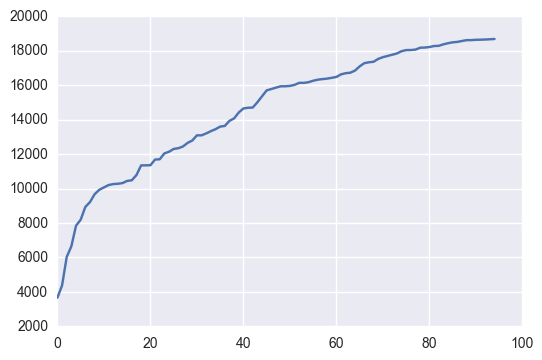

In [6]:
plt.plot(sorted(train_meta['sum_fpkm']))

### Optional filtering by total fpkm count

In [7]:
#test_meta = test_meta[test_meta['sum_fpkm'] > 15000]
#train_meta = train_meta[train_meta['sum_fpkm'] > 10000]

#test_fpkm =  test_fpkm.ix[test_meta.index]
#train_fpkm = train_fpkm.ix[train_meta.index]

In [8]:
test_meta.shape, train_meta.shape

((32, 3), (95, 33))

### exclude BAL 18,19

In [9]:
to_remove = ['BAL18','BAL19']
new_index = [i for i in train_fpkm.index if not any(rem in i for rem in to_remove)]
train_fpkm = train_fpkm.ix[new_index]
train_meta = train_meta.ix[new_index]

In [10]:
train_meta['Pneum'].value_counts()

False    60
True     34
Name: Pneum, dtype: int64

## Reclassify, Based on Mac's email 9/14/17

In [11]:
old_pos = train_meta[train_meta['Pneum']==True]
old_pos_bals = old_pos['BAL'].values
old_pos_bals

array(['BAL28', 'BAL38', 'BAL48', 'BAL53', 'BAL55', 'BAL64', 'BAL75',
       'BAL75', 'BAL79', 'BAL87', 'BAL87', 'BAL28', 'BAL33', 'BAL33',
       'BAL38', 'BAL45', 'BAL46', 'BAL46', 'BAL49', 'BAL50', 'BAL51',
       'BAL51', 'BAL53', 'BAL55', 'BAL57', 'BAL60', 'BAL60', 'BAL67',
       'BAL67', 'BAL79', 'BAL83', 'BAL83', 'BAL86', 'BAL86'], dtype=object)

In [13]:
## Based on Mac's email 9/14/17
f = open('../data/final_positives.txt','r').readlines()
new_pos_bals = np.array([str('BAL' + i).rstrip() for i in f if len(i)>1])

In [14]:
new_pos_bals.shape

(29,)

In [15]:
train_meta['Pneum'] = train_meta['BAL'].map(lambda x: x in new_pos_bals)
train_meta['Pneum'].value_counts()

False    60
True     34
Name: Pneum, dtype: int64

In [16]:
train_meta.shape

(94, 33)

### Change oral contaminates to negative - create new oral_meta

In [17]:
oral_bals = ['BAL' + str(i) for i in [10, 40, 51, 52, 53, 64, 70, 79]]

In [18]:
oral_meta = train_meta
bal_dict = dict(zip(oral_meta['BAL'],oral_meta['Pneum']))
oral_meta['Pneum'] = oral_meta['BAL'].map(lambda x: False if x in oral_bals else bal_dict[x])

In [19]:
oral_meta['Pneum'].value_counts()

False    69
True     25
Name: Pneum, dtype: int64

## Functions for ML algorithms, AUROC

In [20]:
### Used to get X y data from original counts dataframe. 
### We decided to use sampling=None as up/down-sampling are not easy to intrepret.

def geteven_xy(df, dfm, celltype, sampling=None, norm='zscore'):
    
    '''
    df -> counts
    dfm -> meta data
    celltype -> 'AM' or 'CD163'
    sampling -> 'up', 'down', or None
    normalization -> zscore, 'zero_one' (scales data from 0 to 1), or None
    
    '''
    
    dfm = dfm[dfm['CellType']==celltype]
    y = dfm['Pneum'].values
    df = df.ix[dfm.index]
    #    if z: df = df.apply(lambda x: zscore(x))
    genes = df.columns
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = [i for i in range(len(y)) if y[i]==False]
    
    npos = len(pos)
    nneg = len(neg)

    #print "Num positive: {}".format(len(pos))
    #print "Num negative: {}".format(len(neg))
    if sampling=='down':
        if nneg >= npos:
            neg = random.sample(neg, npos)
        else:
            pos = random.sample(pos, nneg)
    if sampling=='up':
        if nneg >= npos:
            dup_pos = list(np.random.choice(pos, nneg-npos))
            pos = pos + dup_pos ## pos+pos in case not enough in pos
    #            print "duplicated pos:", dup_pos
        else:
            neg = neg + np.random.choice(neg, npos-nneg)

    df = df.ix[(pos+neg),:]
    if norm=='zero_one': 
        for col in df.columns:
            mx = np.max(df[col])
            mn = np.min(df[col])
            df[col] = df[col].map(lambda x: (x - mn)/(mx - mn))
            
    if norm=='zscore': 
        df = df.apply(lambda x: zscore(x))

    dfm = dfm.ix[(pos+neg),:]
    X = np.array(df)
    y = dfm['Pneum'].values
    print "Num pos after sampling: {}".format(len(pos))
    print "Num neg after sampling: {}".format(len(neg))
    #y = y[pos + neg] 
    #X = X[pos + neg] 
    return X,y, genes, df, dfm

### Run the models

In [21]:
def run_model(celltype, n_top_genes, response='original', method='PLSR', 
                       norm=False, random_genes=False, jumble_test=False, jumble_train=False,
                       npcs=5, n_estimators=100, sampling=False, cross_validation='LOO'):
      
    '''
    Retrieves training data, gets top features using cross-validation.
    Retreives test data, filters to top features, predicts.
    
    jumble_train -> jumbles each gene vector in the training data
    n_pcs and n_estimators are for PLSR and RandomForests, respectively
    cross_validation can be leave-one-out (LOO) or Kfold
    random_genes is used as a null model, asking whether the top genes are really better than random.
    
    '''
    
    ### TRAINING
    #################
        
    print "Model = ", celltype
    print "Method = ", method
    #print "N_Top_Genes = ", n_top_genes
    print "Normalization = ", norm
    
    # Get training data
    if response=='original': dfm = train_meta
    elif response=='oral': dfm = oral_meta
        
    X, y, genes, df, dfm = geteven_xy(train_fpkm, train_meta, celltype=celltype, norm=norm, sampling=sampling)

    if jumble_train:
        print "---- Entire training set is jumbled ----\n"
        df = df.apply(np.random.permutation)
        X = np.array(df)
        
    # Get top features using cross-validation
    ##############
    feature_inds = get_top_genes_cross_validation(X, y, 
                            method=method, cross_validation=cross_validation, 
                            n_pcs=npcs, n_estimators=n_estimators, n_top_genes=n_top_genes)

    ## TRAIN METRICS
    #print "Q Squared: {0:.2f} \n".format(Q2)
    #num_neg_correct = sum([(e < 0.5) for e in neg_err])
    #num_pos_correct = sum([(e < 0.5) for e in pos_err])
    
    #print "\n===== Training ======"
    #print "Negative: {0:.3f} ({1}/{2}) ".format(neg_accuracy_train, num_neg_correct, len(neg_err))
    #print "Positive: {0:.3f} ({1}/{2}) ".format(pos_accuracy_train, num_pos_correct, len(pos_err))
    
    
    ## Get most common genes from each LOO model
    ##############
    all_top_feature_inds = [g for m in feature_inds for g in m]
    c = Counter(all_top_feature_inds)
    top_inds = [i[0] for i in c.most_common(n_top_genes)]
    top_genes_train = [genes[i] for i in top_inds]
    
    
    ## SWITCH OUT TOP GENES WITH RANDOM GENES
    ##############
    if random_genes:
        top_genes_train = np.random.choice(genes, n_top_genes)
        print "\n **Genes for testing are RANDOM** \n"

    
    ### BUILDING PREDICTIVE MODEL with top genes
    ##############
    X_train = np.array(df[top_genes_train])
    y_train = np.array(dfm['Pneum'])
    
    
    ### GET TEST SET, FILTER TO HAVE ONLY TOP FEATURES
    ############
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(test_fpkm, test_meta, celltype=celltype, norm=norm, sampling=False)
    X_test = np.array(df_test[top_genes_train])
    
    ### TESTING WITH ACTUAL (non-jumbled) GENES
    ###############
    print "\n===== Testing ====="
    
    if method=='PLSR': 
        model = PLSRegression(5, scale=True)
    elif method=='RandomForests': 
        model = RandomForestRegressor(n_estimators=n_estimators)
    else: 
        print "Method {} not recognized".format(method)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auroc_data = auroc_calc(y_test, y_pred, print_stats=True)

    return auroc_data

### Calculate cross-validation metrics, retrieve top genes

In [22]:
def get_top_genes_cross_validation(X, y, n_pcs, n_estimators, n_top_genes, method='PLSR', cross_validation='LOO', k=5, n_splits=10):

    '''
    This function takes X and y data, and does cross-validation 
    to get training statistics and a list of the n_top_genes most predictive genes. 
    
    Can do leave-one-out cross-validation ('LOO') or k-folds ('Kfold')
    Can do PLSR or RandomForests
    '''
    
    n_samples = len(X)
    pred = []
    feat_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    if cross_validation=='LOO':
        for sample in range(n_samples):
            samples = range(n_samples)
            samples.remove(sample)
            X_train = X[(samples)]
            y_train = y[(samples)]
            #print X_t.shape    

            if method=='PLSR':### Get VIPs for model built without the LOO sample
                plsv = PLSRegression(n_pcs, scale=False)
                plsv.fit(X_train, y_train)
                vips = vipp(X_train, y_train, plsv.x_scores_, plsv.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                pls = PLSRegression(n_pcs, scale=False)
                pls.fit(X_train_top_features, y_train)
                pred.append(float(pls.predict(loo_sample)))


            elif method=='RandomForests':        ### Get VIPs for model built without the LOO sample
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train, y_train)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[feat_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[feat_inds].T
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train_top_features, y_train)

                #print "prediction: ", float(rfc.predict(loo_sample))
                pred.append(float(rfc.predict(loo_sample)))

            else:
                print "Method {} not found".format(method)

    elif cross_validation=='Kfold':
        y_k = []
        for ki in range(n_splits):
            sample_ind = range(n_samples)
            withheld_samples = random.sample(sample_ind, k)
            lo_samples = X[withheld_samples]
            for s in withheld_samples:
                sample_ind.remove(s)
            X_train = X[(sample_ind)]
            y_train = y[(sample_ind)]
            
            if method=='PLSR':
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train, y_train)
                vips = vipp(X_train, y_train, model.x_scores_, model.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                #pred.append(float(.predict(loo_sample)))
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                
            elif method=='RandomForests':
                model = RandomForestRegressor(n_estimators=n_estimators)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                
                X_top_features = X.T[vip_inds].T
                
            elif method=='SVM':
                model = SVC()
            else:
                print "Method not found"
            
            for s in withheld_samples:
                pred.append(float(model.predict(X_top_features[s].reshape((1, -1)))))
                y_k.append(y[s])
        y = y_k

    return feat_inds_all


### Calculation the Area Under Reciever Operating Curve (AUROC)

In [23]:
def auroc_calc(y_test, y_pred, print_stats=False):

    neg_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==0])
    pos_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==1])
    
    ### Plot predictions
    plt.plot(neg_preds, label='neg')
    plt.plot(pos_preds, label='pos')
    plt.xlabel("Sample index")
    plt.ylabel("Prediction")
    plt.legend()
    
    ### Iterate over various cutoffs (c) (default is c=0.5)
    ### Analogous to lowering and raising a horizontal bar in the prediction figure above.
    
    auroc_data = []
    ### range here must be beyond [0,1] if there are predictions outside that range
    for c in np.arange(-1, 2, 0.01):
        
        # TPR = # correctly classified negatives / total negatives
        neg_corr = sum([(pred < c) for pred in neg_preds])
        TNR = float(neg_corr) / len(neg_preds)
        
        pos_corr = sum([(e > c) for e in pos_preds])
        FNR = 1 - ( float(pos_corr) / len(pos_preds) )
                   
        auroc_data.append((FNR, TNR))

    return auroc_data

### Now actually run functions 

### AM,

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 14
Num neg after sampling: 35
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


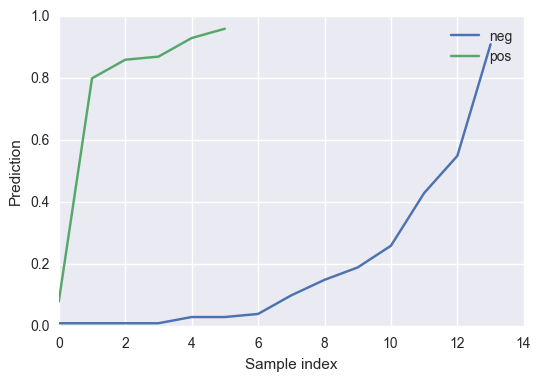

In [25]:
auroc_rf_am_11 = run_model(celltype='AM', response='original', n_top_genes=11, jumble_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

## Plot AUROC Curves

In [15]:

#plt.plot(*zip(*auroc_rf_am_100), label='100 genes')
plt.plot(*zip(*auroc_rf_am_11), label='11 genes')
#plt.plot(*zip(*auroc_rf_am_5), label='5 genes')
plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
plt.title("AUROC, AM models")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.legend(bbox_to_anchor=(1.2, 0.5))


NameError: name 'auroc_rf_am_11' is not defined

   ### CD163, PLSR

In [26]:
auroc_163_rf_11 = run_model(celltype='CD163', response='original', n_top_genes=11, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

TypeError: run_model() got an unexpected keyword argument 'zero_train'

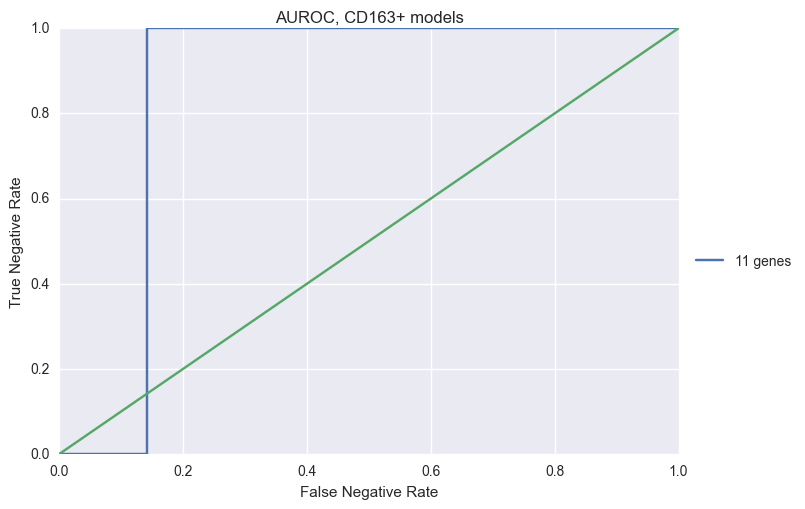

In [37]:
#plt.plot(*zip(*auroc_163_oral_PLSR), label='oral PLS')
#plt.plot(*zip(*auroc_163_rf_100), label='100 genes')
plt.plot(*zip(*auroc_163_rf_11), label='11 genes')
#plt.plot(*zip(*auroc_163_oral_RF), label='oral RF')
#plt.plot(*zip(*auroc_163_RF), label='RF')
plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
plt.title("AUROC, CD163+ models")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.legend(bbox_to_anchor=(1.2, 0.5))